# 1. Setup

In [2]:
from urllib.request import urlretrieve

import plotly.express as px

from utils import *

# 2. Prepare data

## 2.1. Download

In [3]:
def download_nhts():
    url = 'https://nhts.ornl.gov/assets/2016/download/csv.zip'
    outpath = '../data/nhts/2017/data.zip'
    urlretrieve(url, mkfile(outpath))
    
# download_nhts()

In [4]:
pd.read_csv('../data/nhts/2017/trippub.csv', nrows=2)

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300


## Trips table

In [9]:
def get_trip_data(overwrite=False):
    outpath = Path('../data/nhts/trips.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    trip = pd.read_csv('../data/nhts/2017/trippub.csv').rename(columns=str.lower)
    df = Pdf()
    def cut(col: str, bins: list[float], labels: list[str]) -> pd.Categorical:
        return pd.cut(trip[col], [-INF] + bins + [INF], True, labels)
    def classify(col: str, mapping: dict) -> pd.Categorical:
        cats = Series(list(mapping.values())).drop_duplicates().to_list()
        return pd.Categorical(trip[col].map(mapping), categories=cats)
    ## Deterrence measures
    df['Distance'] = trip['trpmiles'] * MI2M / 1000 # in km
    df['Duration'] = trip['trvlcmin'] # in minutes
    df['Speed'] = (df.Distance / (df.Duration / 60)) # in km/h
    for col, vmax in D(Distance=200, Duration=120, Speed=100).items():
        df.loc[(df[col] <= 0) | (df[col] > vmax), col] = np.nan
    df['LogDistance'] = np.log10(1 + df.Distance * 1000) # distance in meters
    # estimated gas price in $ assuming a constant mileage of 20 mi/ga
    # df['Cost'] = (trip['gasprice'] / 100) * (df.Distance * 1000 / MI2M) / 20
    df['TripWeight'] = normalize(trip['wttrdfin'])
    ## Trip attributes
    df['HomeBased'] = (trip['trippurp'] == 'NHB').map({False: 'yes', True: 'no'})
    df['Purpose'] = classify('whytrp90', {1: 'work', 2: 'work', 3: 'shopping',
                                          4: 'social', 5: 'social', 6: 'medical',
                                          8: 'social', 10: 'recreation'})
    df['Mode'] = classify('trptrans', {x: 'drive' for x in [3, 4, 5, 6, 17, 18]} | 
                                      {x: 'transit' for x in [10, 11, 12, 13, 14, 15, 16]} |
                                      {1: 'walk', 2: 'bike'})
    df['VehType'] = classify('vehtype', {1: 'car', 2: 'van', 3: 'suv', 4: 'pickup'} | 
                             {x: 'other' for x in [-1, 5, 6, 7]})
    df['Weekend'] = classify('tdwknd', {1: 'yes', 2: 'no'})
    df['Occupancy'] = cut('numontrp', [1, 2], ['single', 'pair', 'multiple'])
    df['GasPrice'] = cut('gasprice', [233, 267], ['low', 'mid', 'high'])
    df['StayTime'] = cut('dweltime', [15, 60, 480], ['short', 'mid', 'long', 'very_long'])
    df['StartTime'] = (pd.cut(trip['strttime'], [0, 600, 900, 1600, 1900, 2400], labels=[
        'off_peak', 'morn_peak', 'off_peak', 'eve_peak', 'off_peak'], ordered=False)
                       .cat.reorder_categories(['morn_peak', 'eve_peak', 'off_peak']))
    # df['EndTime'] = (pd.cut(trip['endtime'], [0, 600, 900, 1600, 1900, 2400], labels=[
    #     'off_peak', 'morn_peak', 'off_peak', 'eve_peak', 'off_peak'], ordered=False)
    #                    .cat.reorder_categories(['morn_peak', 'eve_peak', 'off_peak']))
    ## SES of respondent/household
    # df['Age'] = normalize(trip['r_age'].clip(0, 80))
    df['AgeGrp'] = cut('r_age', [0, 30, 64], ['n/a', 'young', 'mid', 'senior'])
    df['Sex'] = classify('r_sex', {1: 'male', 2: 'female'})
    df['Race'] = classify('hh_race', {1: 'white'} | {x: 'nonwhite' for x in [2, 3, 4, 5, 6]})
    df['Hispanic'] = classify('hh_hisp', {1: 'yes', 2: 'no'})
    df['Education'] = cut('educ', [0, 2], ['n/a', 'school', 'college'])
    df['Worker'] = classify('worker', {1: 'yes', 2: 'no'})
    df['Income'] = cut('hhfaminc', [0, 5, 7], ['n/a', 'low', 'mid', 'high'])
    df['HomeOwn'] = classify('homeown', {1: 'own', 2: 'rent'})
    ## Origin/destination attributes
    df['Region'] = cut('census_r', [1, 2, 3], ['northeast', 'midwest', 'south', 'west'])
    df['MSAKind'] = classify('msacat', {1: 'big_rail', 2: 'big_norail', 3: 'small', 4: 'not_msa'})
    df['UrbanO'] = classify('obhur', D(C='urban', S='suburban', T='suburban', U='urban', R='rural'))
    df['UrbanD'] = classify('dbhur', D(C='urban', S='suburban', T='suburban', U='urban', R='rural'))
    df['PopDensityO'] = cut('otppopdn', [0, 1000, 4000], ['n/a', 'low', 'mid', 'high'])
    df['PopDensityD'] = cut('dtppopdn', [0, 1000, 4000], ['n/a', 'low', 'mid', 'high'])
    df['HouseDensityO'] = cut('otresdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['HouseDensityD'] = cut('dtresdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['EmpDensityO'] = cut('oteempdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    df['EmpDensityD'] = cut('dteempdn', [0, 500, 2000], ['n/a', 'low', 'mid', 'high'])
    ## Remove bad dataa
    df = df.replace('n/a', None)
    print('NaNs: ' + ' '.join([f'{k}={v:,}' for k, v in df.isna().sum().items() if v > 0]))
    df = df.dropna().reset_index(drop=1)
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype(CAT)
    df.to_parquet(mkfile(outpath))
    return df

trips = get_trip_data(overwrite=1).disp() # t=0:08

NaNs: Distance=9,530 Duration=13,345 Speed=19,562 LogDistance=9,530 Purpose=35,779 Mode=9,540 VehType=458 StartTime=544 AgeGrp=1,216 Sex=711 Race=19,553 Hispanic=1,002 Education=65,579 Worker=79,323 Income=24,340 HomeOwn=6,308 UrbanO=980 UrbanD=962 PopDensityO=973 PopDensityD=955 HouseDensityO=973 HouseDensityD=955 EmpDensityO=973 EmpDensityD=955
739,164 rows x 32 cols; Memory: 47.2 MiB


,Distance,Duration,Speed,LogDistance,TripWeight,HomeBased,Purpose,Mode,VehType,Weekend,...,Region,MSAKind,UrbanO,UrbanD,PopDensityO,PopDensityD,HouseDensityO,HouseDensityD,EmpDensityO,EmpDensityD
,<float64>,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,8.439379,15.0,33.757516,3.926362,0.006319,yes,social,drive,car,no,...,south,small,suburban,suburban,mid,low,mid,low,mid,low


# 3. Analyze

In [6]:
# for col in sorted(trips.select_dtypes(CAT).columns):
#     print('*' * 50, f'{col}', sep='\n') #  (n={data[col].dropna().size:,})
#     print(', '.join([f'{k}={v:,}' for k, v in data[col].value_counts().sort_index().items()]))

## 3.1. Target vars (deterrence)

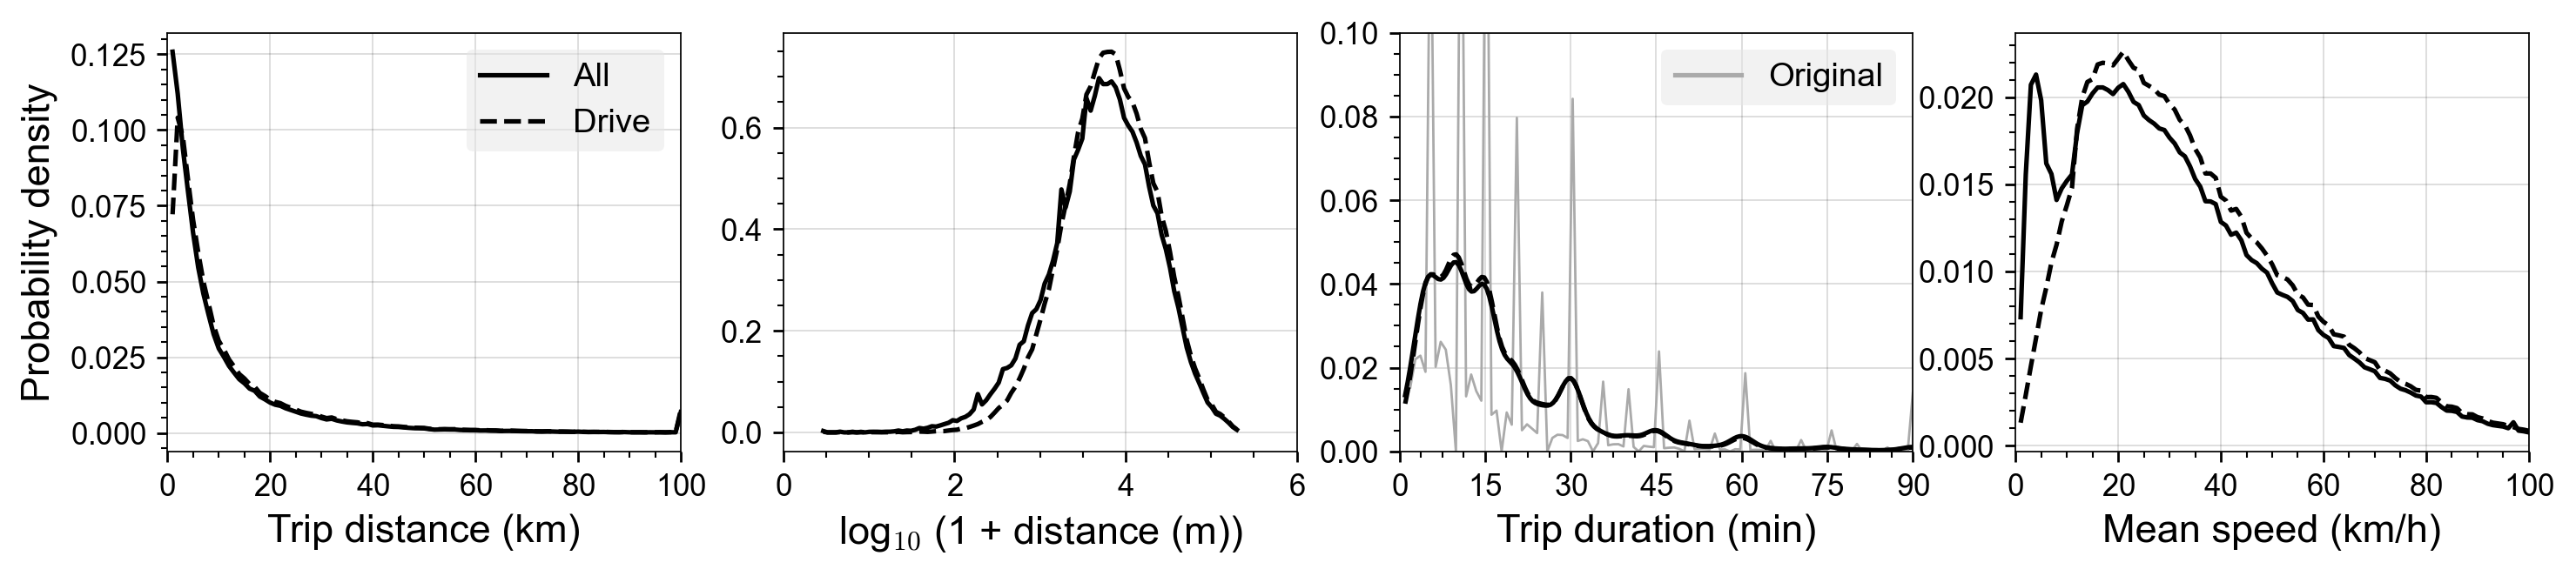

In [7]:
def fig_deterrence_distr(tds=trips, size=(14, 2.5), dpi=150):
    # sg = pd.read_parquet('../data/pois/odm2.parquet', filters=[
    #     ('duration', '>', 0), ('purpose', '==', 'Overall')
    # ], columns=['visitors', 'distance', 'duration'])
    # sg.distance /= 1000; sg.duration /= 60
    # sg['speed'] = sg.distance / sg.duration * 60
    def hist(x, vmax=None, bins=100, wt=None):
        y, x = np.histogram(x.clip(0, vmax), bins, density=True, weights=wt)
        return x[1:], y
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi)
    drive = tds.query('Mode == "drive"')
    ## Distance
    ax = pplot(axes[0], ylog=0, xlab='Trip distance (km)',
               ylab='Probability density', xlim=(0, 100))
    ax.plot(*hist(tds.Distance, 100), color='k', ls='-', label='TDS (all)')
    ax.plot(*hist(drive.Distance, 100), color='k', ls='--', label='TDS (drive)')
    # ax.plot(*hist(sg.distance, 100), color='b', label='LBS (drive)')
    ax.legend(loc='upper right', handles=[mpl.lines.Line2D(
        [0], [0], color=c, ls=ls, label=x) for x, c, ls in [
            ('All', 'k', '-'), ('Drive', 'k', '--')]])
    ## LogDistance
    ax = pplot(axes[1], ylog=0, xlab='log$_{10}$ (1 + distance (m))',
               ylab='Probability density', xlim=(0, 6))
    ax.plot(*hist(tds.LogDistance, 100), color='k', ls='-', label='TDS (all)')
    ax.plot(*hist(drive.LogDistance, 100), color='k', ls='--', label='TDS (drive)')
    # ax.plot(*hist(np.log10(1 + sg.distance * 1000), 100), color='b', label='LBS (drive)')
    ax.set_ylabel('')
    ## Duration
    ax = pplot(axes[2], xlab='Trip duration (min)', ylim=(0, 0.1), xlim=(0, 90))
    ax.plot(*hist(tds.Duration, 90), color='#aaa', lw=0.8, label='TDS (original; all)')
    ax = sns.kdeplot(tds.Duration, ax=ax, bw_adjust=1.75, clip=(1, 90), 
                     color='k', ls='-', label='TDS (smooth; all)')
    ax = sns.kdeplot(drive.Duration, ax=ax, bw_adjust=1.75, clip=(1, 90), 
                     color='k', ls='--', label='TDS (smooth; drive)')
    ax.set_ylabel('')
    # ax.plot(*hist(sg.duration, 90), color='b', label='LBS (drive)')
    ax.set_xticks(np.arange(0, 91, 15))
    ax.legend(loc='upper right', handles=[mpl.lines.Line2D(
        [0], [0], color='#aaa', label='Original')])
    ## Speed
    ax = pplot(axes[3], xlab='Mean speed (km/h)', xlim=(0, 100))
    ax.plot(*hist(tds.Speed), color='k', ls='-', label='TDS (all)')
    ax.plot(*hist(drive.Speed), color='k', ls='--', label='TDS (drive)')
    # ax.plot(*hist(sg.speed), color='b', label='LBS (drive)')

x = fig_deterrence_distr(dpi=250); x # t=0:09

## 3.2. Covariates (discrete vars)

### 3.2.1. Sample sizes

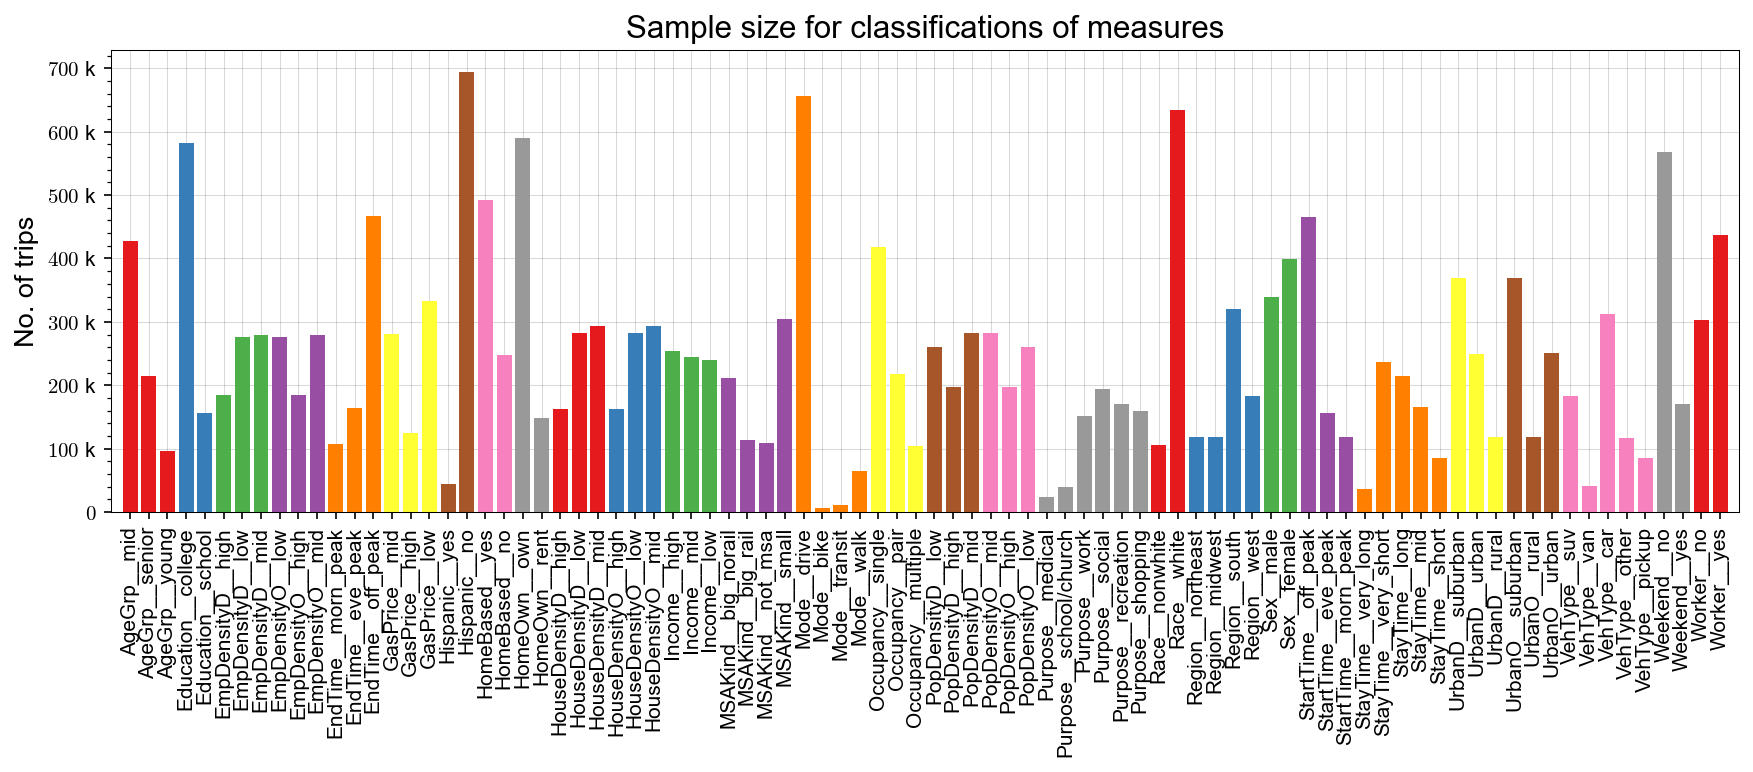

In [8]:
def plot_sample_sizes(data, size=(14, 4), dpi=150):
    df = pd.concat([data[col].value_counts().rename_axis('subcat')
                    .reset_index().assign(cat=col) 
                    for col in data.select_dtypes(CAT)])
    df = df.sort_values('cat')
    df['label'] = df.cat + '__' + df.subcat
    df['color'] = df.cat.map(dict(zip(df.cat.unique(), sns.color_palette(
        'Set1', df.cat.nunique()))))
    ax = pplot(size=size, dpi=dpi, ylab='No. of trips', xlim=(-1, len(df)), 
               title='Sample size for classifications of measures', yeng=1)
    ax.bar(df.label, df['count'], color=df.color)
    ax.tick_params(which='minor', bottom=False)
    plt.xticks(rotation=90)

plot_sample_sizes(trips, dpi=150)